In [1]:
# plot feature importance using built-in function
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
import numpy as np
from xgboost import plot_importance
from matplotlib import pyplot
# load data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


In [2]:
df_train_xgboost = df_train
df_test_xgboost = df_test

print(df_train_xgboost.head())

def asignarMetros(metroscubiertos, metrostotales):
    if (metroscubiertos != 0 and metrostotales == 0):
        return metroscubiertos
    else:
        return metrostotales
    
def asignarMetrosLibres(metroscubiertos, metrostotales):
    if (metroscubiertos != metrostotales):
        return metrostotales-metroscubiertos
    else:
        return 0

df_train_xgboost['fecha'] = pd.to_datetime(df_train_xgboost['fecha'])
df_train_xgboost['year'] = df_train_xgboost['fecha'].dt.year
df_train_xgboost['month']= df_train_xgboost['fecha'].dt.month
df_train_xgboost['day']= df_train_xgboost['fecha'].dt.day
df_train_xgboost.drop(["fecha"], axis=1, inplace=True)

df_test_xgboost['fecha'] = pd.to_datetime(df_test_xgboost['fecha'])
df_test_xgboost['year'] = df_test_xgboost['fecha'].dt.year
df_test_xgboost['month']= df_test_xgboost['fecha'].dt.month
df_test_xgboost['day']= df_test_xgboost['fecha'].dt.day
df_test_xgboost.drop(["fecha"], axis=1, inplace=True)
    
#df_train_xgboost['metrostotales'].fillna(0, inplace=True)
#df_train_xgboost['metrostotales'] = df_train_xgboost.apply(lambda x: asignarMetros(x['metroscubiertos'],x['metrostotales']),axis=1)
#df_train_xgboost['metroslibres'] = df_train_xgboost.apply(lambda x: asignarMetrosLibres(x['metroscubiertos'],x['metrostotales']),axis=1)

#df_test_xgboost['metrostotales'].fillna(0, inplace=True)
#df_test_xgboost['metrostotales'] = df_test_xgboost.apply(lambda x: asignarMetros(x['metroscubiertos'],x['metrostotales']),axis=1)
#df_test_xgboost['metroslibres'] = df_test_xgboost.apply(lambda x: asignarMetrosLibres(x['metroscubiertos'],x['metrostotales']),axis=1)

       id                                             titulo  \
0  254099                                  depto. tipo a-402   
1   53461                     condominio horizontal en venta   
2  247984              casa en venta urbi 3 recamaras tonala   
3  209067  casa sola en toluca zinacantepec con credito i...   
4  185997                                     paseos del sol   

                                         descripcion     tipodepropiedad  \
0  depto. interior de 80.15m2, consta de sala com...         Apartamento   
1  <p>entre sonora y guerrero, atr&aacute;s del h...  Casa en condominio   
2  descripcion \nla mejor ubicacion residencial e...                Casa   
3  casa en privada con caseta de vigilancia casas...                Casa   
4  bonito departamento en excelentes condiciones ...         Apartamento   

                         direccion                  ciudad         provincia  \
0  Avenida Division del Norte 2005           Benito Juárez  Distrito Federal  

(240000, 18)
(240000, 70)


c:\users\manuel\appdata\local\programs\python\python37-32\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\manuel\appdata\local\programs\python\python37-32\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


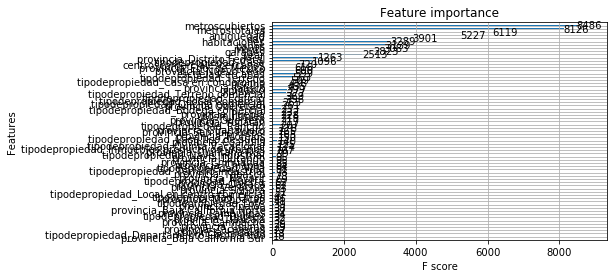

In [3]:
#----------------PREPROCESAMIENTO----------------

#df_train_xgboost = df_train_xgboost.drop(['fecha','titulo','descripcion','direccion','idzona','lat','lng'], axis=1)
#df_train_xgboost = df_train_xgboost.fillna(value = {'ciudad': 0, 'provincia': 0, 'tipodepropiedad': 0})

df_train_xgboost = df_train_xgboost.drop(['ciudad','titulo','descripcion','direccion','idzona','lat','lng'], axis=1)
df_test_xgboost = df_test_xgboost.drop(['ciudad','titulo','descripcion','direccion','idzona','lat','lng'], axis=1)
#df_train_xgboost = df_train_xgboost.fillna(value = {'provincia': 0, 'tipodepropiedad': 0})

print(df_train_xgboost.shape)
#XGBoost maneja los NaNs, ver despues si lo dejamos como esta

df_train_xgboost = pd.get_dummies(df_train_xgboost, drop_first=True)#, sparse = True)
df_test_xgboost = pd.get_dummies(df_test_xgboost, drop_first=True)#, sparse = True)

print(df_train_xgboost.shape)
precio = df_train_xgboost['precio']
df_train_xgboost.drop(labels=['precio'], axis=1,inplace = True)
df_train_xgboost.insert(len(df_train_xgboost.columns), 'Precio', precio)

X_train, y_train = df_train_xgboost.iloc[:,:-1],df_train_xgboost.iloc[:,-1]

df_test_xgboost['tipodepropiedad_Garage'] = 0
df_test_xgboost['tipodepropiedad_Hospedaje'] = 0
df_test_xgboost = df_test_xgboost[list(X_train.columns.values)]


xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.7, learning_rate = 0.05,
                max_depth = 7, min_child_weight = 4, n_estimators = 700, nthread = 4, subsample = 0.7, silent = 1)

xg_reg.fit(X_train,y_train)

plot_importance(xg_reg)
pyplot.show()

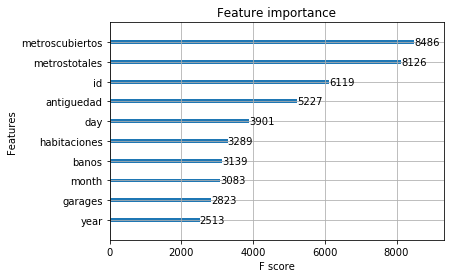

In [4]:
plot_importance(xg_reg, max_num_features = 10)
pyplot.show()

In [ ]:
def RMSLE(actual, pred):
    return (np.mean((np.log(actual + 1) - np.log(pred + 1)) ** 2)) **.5

dummy_rmsle = RMSLE(y_test, pred)
dummy_rmsle_train = RMSLE(y_train, dummy.predict(X_train))
print(f"RMSLE DummyRegressor (train): {dummy_rmsle_train:.5f}")
print(f"RMSLE DummyRegressor: {dummy_rmsle:.5f}")